In [3]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np
import stumpy
import ruptures as rpt

In [4]:
import sys
sys.path.append('../')
from Utils.explanations import NNSegment 

### Create Synthetic Dataset 

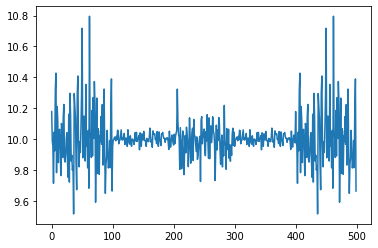

In [112]:
X_synthetic = [] 
for _ in range(0,50):
    x1 = np.random.normal(10, 0.2, 100)
    x2 = np.random.normal(10, 0.03, 100)
    x3 = np.random.normal(10, 0.1, 100)
    t = list(x1) + list(x2) + list(x3) + list(x2) + list(x1)
    X_synthetic.append(np.asarray(t))
plt.plot(X_synthetic[0])

In [113]:
ground_truth_synthetic = []
for _ in range(0,50):
    ground_truth_synthetic.append([100,200,300,400])

### Load Apnea dataset

In [115]:
annotations = []
ecgs = []

for file_index in range(1,10):
    #file_name = files.split(".")[0]
    ecg = wfdb.rdsamp('datasets/apnea/apnea/a0'+str(file_index))
    ecgs.append(ecg[0].reshape(len(ecg[0])))
    annotation = wfdb.rdann('datasets/apnea/apnea/a0'+str(file_index), extension="apn")
    annotations.append(annotation.symbol)
for file_index in range(10,21):
    #file_name = files.split(".")[0]
    ecg = wfdb.rdsamp('datasets/apnea/apnea/a'+str(file_index))
    ecgs.append(ecg[0].reshape(len(ecg[0])))
    annotation = wfdb.rdann('datasets/apnea/apnea/a'+str(file_index), extension="apn")
    annotations.append(annotation.symbol)

for file_index in range(1,6):
    #file_name = files.split(".")[0]
    ecg = wfdb.rdsamp('datasets/apnea/apnea/b0'+str(file_index))
    ecgs.append(ecg[0].reshape(len(ecg[0])))
    annotation = wfdb.rdann('datasets/apnea/apnea/b0'+str(file_index), extension="apn")
    annotations.append(annotation.symbol)

for file_index in range(1,10):
    #file_name = files.split(".")[0]
    ecg = wfdb.rdsamp('datasets/apnea/apnea/c0'+str(file_index))
    ecgs.append(ecg[0].reshape(len(ecg[0])))
    annotation = wfdb.rdann('datasets/apnea/apnea/c0'+str(file_index), extension="apn")
    annotations.append(annotation.symbol)
for file_index in range(10,11):
    #file_name = files.split(".")[0]
    ecg = wfdb.rdsamp('datasets/apnea/apnea/c'+str(file_index))
    ecgs.append(ecg[0])
    annotation = wfdb.rdann('datasets/apnea/apnea/c'+str(file_index), extension="apn")
    annotations.append(annotation.symbol)

In [116]:
##### Simplify ECG signals by downsampling

In [117]:
simple_ecgs = []
for ecg in ecgs:
    simple_ecgs.append(ecg.reshape(-1, 100).mean(axis=1))

#### Find NNSegment Synthetic Change Points

In [152]:
NNSegment_synthetic_cp = [NNSegment(x,100,4) for x in X_synthetic]

#### Find FLUSS Synthetic Change Points

In [121]:
FLUSS_synthetic_cp = []
for ts in X_synthetic:
    m = 10
    mp = stumpy.stump(ts, m=m)
    L = 200
    cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=4, excl_factor=5)
    FLUSS_synthetic_cp.append(regime_locations)

In [122]:
FLUSS_synthetic_cps = []
for sample in FLUSS_synthetic_cp:
    FLUSS_synthetic_cps.append(sample.sort())

In [123]:
FLUSS_synthetic_cp[10]

array([0, 0, 0])

### Find Bottom Up synthetic segmentation

In [124]:
botup_synthetic_cp = []
for ts in X_synthetic:
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
    number_regimes = 4
    algo = rpt.detection.bottomup.BottomUp(model=model)
    my_bkps = algo.fit_predict(ts, n_bkps=number_regimes)
    botup_synthetic_cp.append(my_bkps)

### Find Dynp synthetic Segmentation

In [125]:
dynp_synthetic_cp = []
for ts in X_synthetic:
    number_regimes = 4
    model = "l2"  # "l2", "rbf"
    algo = rpt.Dynp(model=model).fit(ts)
    my_bkps = algo.predict(n_bkps=number_regimes)
    dynp_synthetic_cp.append(my_bkps)

### FIND FLUSS, NNSegment, Botup, Dynp Apnea Change Points

In [170]:
ground_truth_apnea_cp = []
NNSegment_apnea_cp = []
FLUSS_apnea_cp = []
botup_apnea_cp = []
dynp_apnea_cp = []


for i in range(0,len(simple_ecgs)):
    labels = annotations[i]
    signal = simple_ecgs[i]
    number_regimes = 1
    N_indexes = []

    for label_index in range(0,len(labels)-1):
        if labels[label_index] != labels[label_index + 1]:
            number_regimes += 1
            N_indexes.append((label_index+1)*60)
    
    ground_truth_apnea_cp.append(N_indexes)
    NNSegment_apnea_cp.append(NNSegment(signal,60,number_regimes-1,))
    m = 60
    mp = stumpy.stump(signal, m=m)
    L = 60
    cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=number_regimes, excl_factor=5)
    FLUSS_apnea_cp.append(regime_locations)
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
    algo = rpt.detection.bottomup.BottomUp(model=model)
    my_bkps = algo.fit_predict(signal, n_bkps=number_regimes)
    botup_apnea_cp.append(my_bkps)
    model = "l2"  # "l2", "rbf"
    algo = rpt.Dynp(model=model).fit(ts)
    my_bkps = algo.predict(n_bkps=number_regimes)
    dynp_apnea_cp.append(my_bkps)

In [171]:
FLUSS_apnea_cps = []
for sample in FLUSS_apnea_cp:
    FLUSS_apnea_cps.append(sample.sort())

In [172]:
def calculate_Fscore(cps, ground_truths, time_series):
    samples_hits = []
    total_true_cp = 0
    total_predicted_cp = 0
    wrong_score = 0
    for sample_idx in range(0,len(cps)):
        sample_hits = 0
        tolerance = len(time_series[sample_idx])/10
        ground_truth = ground_truths[sample_idx]
        total_predicted_cp += len(cps[sample_idx])
        total_true_cp += len(ground_truth)
        cp_regions = []
        for gt_cps in ground_truth: 
            cp_regions.append(list(np.arange(gt_cps-tolerance,gt_cps+tolerance)))
        
        cp_possible = [item for sublist in cp_regions for item in sublist]
        
        
        for i in cps[sample_idx]:
                if i in cp_possible:
                    sample_hits = sample_hits + 1
        samples_hits.append(sample_hits)
                
    
    
    precision = sum(samples_hits)/(total_predicted_cp)

    recall = sum(samples_hits)/(total_true_cp)
    
    return 2 * (precision * recall)/(precision + recall+1)

### Calculate F Score on change points for synthetic and apnea datasets

In [173]:

print(calculate_Fscore(NNSegment_synthetic_cp, ground_truth_synthetic, X_synthetic))
print(calculate_Fscore(FLUSS_synthetic_cp, ground_truth_synthetic, X_synthetic))
print(calculate_Fscore(botup_synthetic_cp, ground_truth_synthetic, X_synthetic))
print(calculate_Fscore(dynp_synthetic_cp, ground_truth_synthetic, X_synthetic))

print(calculate_Fscore(NNSegment_apnea_cp, ground_truth_apnea_cp, simple_ecgs))
print(calculate_Fscore(FLUSS_apnea_cp, ground_truth_apnea_cp, simple_ecgs))
print(calculate_Fscore(botup_apnea_cp, ground_truth_apnea_cp, simple_ecgs))
print(calculate_Fscore(dynp_apnea_cp, ground_truth_apnea_cp, simple_ecgs))


0.664440734557596
0.0
0.28034466251795115
0.2300102354145343
0.2330866807610994
0.24030246069719755
0.25788217678161995
0.20029729668027163


In [174]:
def calculate_hausdorff(cps, ground_truths, ts):
    samples_hausdorff = []
    wrong_score = 0
    for sample in range(0,len(cps)):
        max_distance = 0
        ground_truth = ground_truths[sample][:len(cps[sample])]
        for i in range(0,len(ground_truth)):
            if np.abs(cps[sample][i]-ground_truth[i]) > max_distance:
                max_distance = np.abs(cps[sample][i]-ground_truth[i])
        samples_hausdorff.append(max_distance/len(ts[sample]))

    return np.mean(samples_hausdorff)

### Calculate Hausdorff measure on change points for synthetic and apnea datasets

In [175]:
print(calculate_hausdorff(NNSegment_synthetic_cp, ground_truth_synthetic, X_synthetic))
print(calculate_hausdorff(FLUSS_synthetic_cp, ground_truth_synthetic, X_synthetic))
print(calculate_hausdorff(botup_synthetic_cp, ground_truth_synthetic, X_synthetic))
print(calculate_hausdorff(dynp_synthetic_cp, ground_truth_synthetic, X_synthetic))

0.08012000000000001
0.6000000000000001
0.33520000000000005
0.3668


In [176]:
print(calculate_hausdorff(NNSegment_apnea_cp, ground_truth_apnea_cp, simple_ecgs))
print(calculate_hausdorff(FLUSS_apnea_cp, ground_truth_apnea_cp, simple_ecgs))
print(calculate_hausdorff(botup_apnea_cp, ground_truth_apnea_cp, simple_ecgs))
print(calculate_hausdorff(dynp_apnea_cp, ground_truth_apnea_cp, simple_ecgs))

0.34589008750037065
0.3971152349175042
0.3990815790351534
0.7395672626989985
